# **SMOD Analyzer (Japan example)**

## **Initial global setting**


Authorize your Google Drive account to mount Google Drive for this notebook. Then, specify the directory location of your SMOD-Analyzer resources.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

program_location = '/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD'

Mounted at /content/drive


Specify the target country ISO:

In [2]:
ISO = 'JPN'

NOTE: Find the most appropriate UTM for your target AOI.
https://epsg.io/

* NGA - WGS 84/UTM zone 31N (EPSG:26331)
* IND - WGS 84/UTM zone 42N - 44N - 47N (EPSG:32642, EPSG:32644, EPSG:32647)
* JPN - WGS 84/UTM zone 53N (EPSG:32653)

In [3]:
UTM_crs = 'EPSG:32653'

Specify the unique ID for each ADM-2 boundary area (for WHO ADM2 data, it is 'GUID')

In [35]:
unique_ID = 'GUID'

## **Workspace set-up**
Install the required packages and ensure that the data and output directories are correctly set.

In [4]:
RW_engine = 'pyogrio'
rasterSwitch = 'NO'

Mounting your GoogleDrive

Importing module(s)

In [5]:
!pip install geopandas rioxarray geemap rasterio import_ipynb pyshp pycrs pyogrio xarray-spatial exactextract

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.6 MB/s eta 0:00:00
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=5a61cec8b0997ec404b16b280fcbb951ddf84865cf33062f572beb3fb27692e8
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Successfully built pycrs


In [6]:
# Colab default packages
import io
import os
import types
import sys
import glob
import importlib
import numpy as np
import pandas as pd
import json
import datetime
from shapely.geometry import mapping
from shapely import geometry
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import exactextract
import seaborn as sns

# Temporarily installed packages
import geopandas as gpd
import xarray as xr
from xrspatial import zonal_stats
import rioxarray
import rasterio
from rasterio import features
import geemap
import pyogrio
import pycrs
import import_ipynb
from matplotlib.ticker import ScalarFormatter

# Import external files
os.chdir(program_location)
!pwd

sys.path.append(program_location)

import tools
importlib.reload(tools)

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD


<module 'tools' from '/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/tools.py'>

Generating an 'output' foldirectory in the target city directory

In [7]:
data_loc = os.path.join(os.getcwd(), 'data')
output_loc = os.path.join(os.getcwd(), 'output')

print(data_loc)
print(output_loc)

/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/output


In [8]:
if not os.path.exists(output_loc):
    os.mkdir(output_loc)

## **Construct a global Xarray dataset**

In [9]:
# Read the downloaded VIIRS rasters form disk
list_rasters = sorted(glob.glob(os.path.join(data_loc, 'smod_raw', '*.tif')))

In [10]:
for i in list_rasters:
  print(i)

/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_1975.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_1980.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_1985.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_1990.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_1995.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_2000.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_2005.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_2010.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_2015.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_2020.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-SMOD/data/smod_raw/smod_2025.tif
/content/drive/MyDrive/Colab Notebooks/Analyzing GHS-S

In [11]:
# Get a national-level AOI
# Import: If you have your custom AOI, store that shapefile and specify it.
src_aoi = os.path.join(data_loc, 'shp', 'WHO_adm2', 'GLOBAL_ADM2.shp')

gdf_aoi = tools.vec_import(RW_engine, src_aoi)

Vector import complete.
GDF size:50368
EPSG:4326


In [16]:
gdf_aoi = gdf_aoi.query('ENDDATE == "9999/12/31"')

In [17]:
# Convert CRS to the CRS of SMOD (i.e. ESRI:54009 - World Mollweide).
gdf_aoi.to_crs('ESRI:54009', inplace = True)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
gdf_aoi.head(5)

,WHO_REGION,ISO_2_CODE,ADM2_NAME,ADM1_NAME,ADM0_NAME,ADM2_CODE,ADM1_CODE,ADM0_CODE,STARTDATE,ENDDATE,...,ADM0_VIZ_N,ADM2_SHAPE,ADM1_SHAPE,ADM0_SHAPE,ADM2_PCODE,ADM1_PCODE,ADM0_PCODE,WHO_SUBREG,CODE,geometry
0,AMRO,SX,SINT MAARTEN,SINT MAARTEN,SINT MAARTEN,None,None,None,2011-01-01,9999/12/31,...,Sint Maarten,None,None,None,None,None,None,None,None,"POLYGON ((-6125010.084 2219264.753, -6124690.7..."
1,AMRO,MF,SAINT MARTIN,SAINT MARTIN,SAINT MARTIN,None,None,None,2004-01-01,9999/12/31,...,Saint Martin,None,None,None,None,None,None,None,None,"POLYGON ((-6120780.41 2225862.136, -6120694.04..."
2,AMRO,AI,ANGUILA,ANGUILA,ANGUILLA,AI001001001000000000,AI001001000000000000,AI001000000000000000,2000-01-01,9999/12/31,...,Anguilla,74168f2a-f330-4d9d-88bb-130e7d4eb4fb,None,None,None,None,None,None,{74168F2A-F330-4D9D-88BB-130E7D4EB4FB},"POLYGON ((-6112825.397 2244374.05, -6113502.38..."
3,AMRO,CW,CURAÇAO,CURAÇAO,CURAÇAO,CW001001001000000000,CW001001000000000000,CW001000000000000000,2011-01-01,9999/12/31,...,Curaçao,None,None,None,None,None,None,None,{A34981E2-33F0-4AA6-8295-0A52D9C4BE8D},"POLYGON ((-6828554.48 1527014.73, -6828279.034..."
4,AMRO,BL,SAINT BARTHELEMY,SAINT BARTHELEMY,SAINT BARTHÉLEMY,BL001001001000000000,BL001001000000000000,BL001000000000000000,2004-01-01,9999/12/31,...,Saint Barthélemy,None,None,None,None,None,None,None,{58F278A3-F67D-4549-8611-F74ED2F7E051},"POLYGON ((-6110042.999 2202239.488, -6110007.1..."


<Projected CRS: ESRI:54009>
Name: World_Mollweide
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: World_Mollweide
- method: Mollweide
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

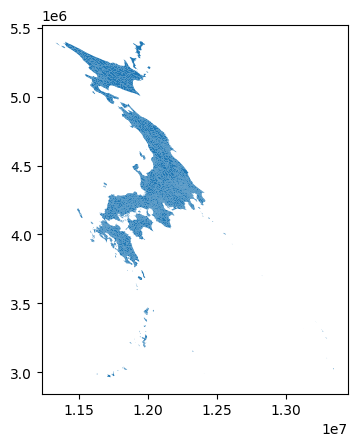

In [19]:
str_query = 'ISO_3_CODE == "' + ISO + '"'

gdf_tar = gdf_aoi.query(str_query).copy()
gdf_tar.plot()
gdf_tar.crs

In [20]:
gdf_tar

,WHO_REGION,ISO_2_CODE,ADM2_NAME,ADM1_NAME,ADM0_NAME,ADM2_CODE,ADM1_CODE,ADM0_CODE,STARTDATE,ENDDATE,...,ADM0_VIZ_N,ADM2_SHAPE,ADM1_SHAPE,ADM0_SHAPE,ADM2_PCODE,ADM1_PCODE,ADM0_PCODE,WHO_SUBREG,CODE,geometry
560,WPRO,JP,HUKIAGETYOO,KAGOSIMA,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((11834521.382 3826809.918, 11835500.9..."
561,WPRO,JP,TORIDESI,IBARAKI,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((12312950.398 4329761.039, 12313104.4..."
562,WPRO,JP,OOTAKIMATI,TIBA,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((12389641.559 4260373.313, 12390588.9..."
563,WPRO,JP,URASOESI,OKINAWA,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((11964752.858 3204925.503, 11965054.3..."
564,WPRO,JP,UDONOMURA,MIE,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((12160079.018 4076558.248, 1216..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,WPRO,JP,IRABUTYOO,OKINAWA,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((11820396.151 3029857.109, 1181..."
3896,WPRO,JP,HIMESIMAMURA,OOITA,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((11770795.52 4077878.406, 11772478.05..."
3897,WPRO,JP,AOGASIMAMURA,TOOKYOO,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((12609601.887 3928807.556, 12608750.8..."
3898,WPRO,JP,KOODUSIMAMURA,TOOKYOO,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((12392879.688 4136464.354, 12395848.5..."


In [21]:
# Construct time coordinate
list_time = []

l_years = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020, 2025, 2030]

for y in l_years:

      time_stamp = str(y) + '-01-01'
      time_stamp = datetime.datetime.strptime(time_stamp, '%Y-%m-%d')

      list_time.append(time_stamp)


# Convert the time list to a time array
time = np.array(list_time)
time_var = xr.Variable('time', time)

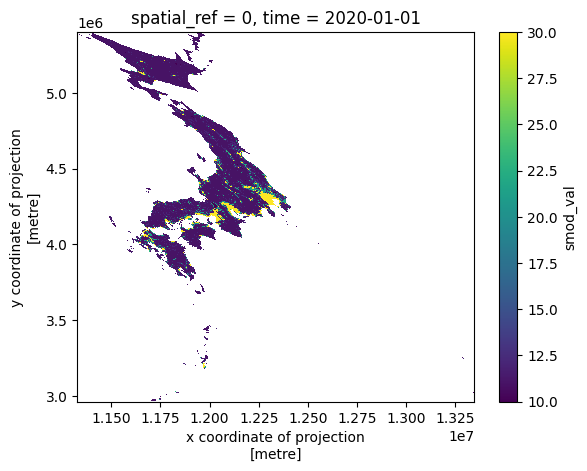

In [22]:
# Construct VIIRS data array
da = xr.concat([rioxarray.open_rasterio(i, masked=True).rio.clip(gdf_tar.geometry.values, gdf_tar.crs, drop=True, invert=False, from_disk=True) for i in list_rasters], dim = time_var)

# Convert the DA to a xarray dataset
ds = da.to_dataset("band")
ds = ds.rename({1: 'smod_val'})

ds['smod_val'].sel(time = '2020-01-01').plot()

In [23]:
ds

<xarray.Dataset> Size: 472MB
Dimensions:      (time: 12, y: 2437, x: 2019)
Coordinates:
  * x            (x) float64 16kB 1.133e+07 1.133e+07 ... 1.334e+07 1.335e+07
  * y            (y) float64 19kB 5.4e+06 5.4e+06 ... 2.966e+06 2.964e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 96B 1975-01-01 1980-01-01 ... 2030-01-01
Data variables:
    smod_val     (time, y, x) float64 472MB nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        30
    STATISTICS_MEAN:           10.329736435403
    STATISTICS_MINIMUM:        10
    STATISTICS_STDDEV:         0.84185298782103
    STATISTICS_VALID_PERCENT:  78.71
    scale_factor:              1.0
    add_offset:                0.0

## **National-level analysis**

In [24]:
# Count non-nan pixels per month.
# Just to be sure there is no count fluctuation (images are consistent over months).

ds['smod_val'].where(~np.isnan(ds['smod_val'])).count(dim=["x", "y"])
ds['smod_val'].count(dim=["x", "y"])

<xarray.DataArray 'smod_val' (time: 12)> Size: 96B
array([377630, 377630, 377630, 377630, 377630, 377630, 377630, 377630,
       377630, 377630, 377630, 377630])
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 96B 1975-01-01 1980-01-01 ... 2030-01-01

**NOTE: Definition of SMOD classes:**

* 30	Urban Centre
* 23	Dense Urban Cluster
* 22	Semi-Dense Urban Cluster
* 21	Suburban or Peri-urban
* 13	Rural Cluster
* 12	Low-density Rural
* 11	Very Low-density Rural
* 10	Rural Grid Cell (general)
* 0	No Population / Not classified / Water bodies

Example of reclassification (there is no definitive rule)
* Urban: 30, 23, 22
* Suburban: 21
* Rural: 13, 12, 11, 10

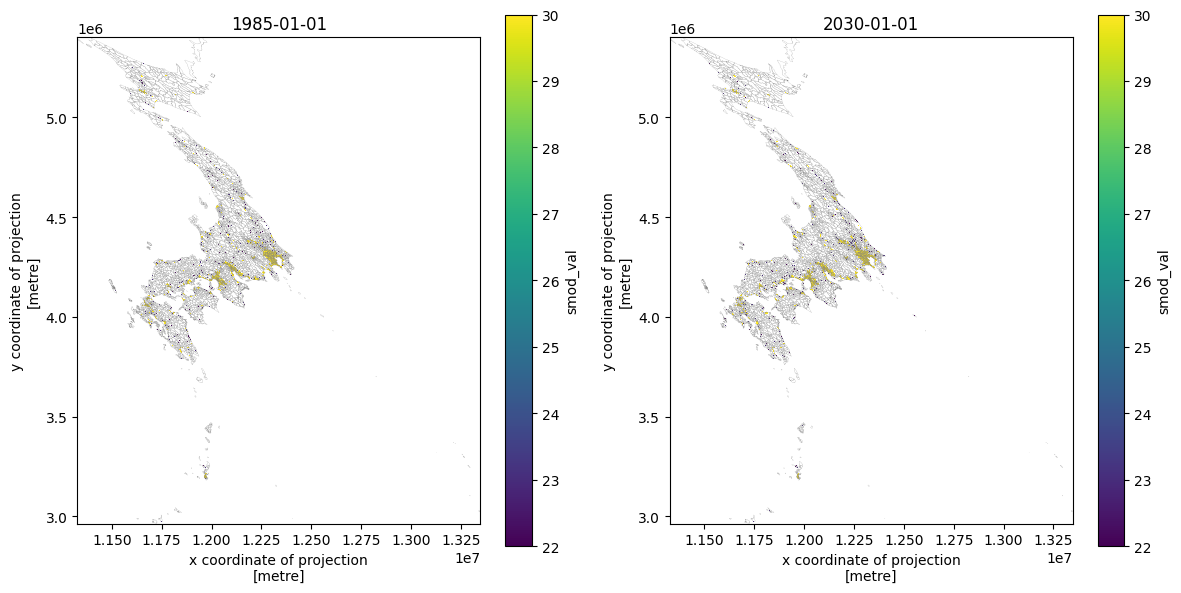

In [25]:
# Plot 1985 Urban vs 2030 Urban to check (Just visual check)

# Define figure and two axes
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Apply common masking condition
masked_ds = ds['smod_val'].where((ds['smod_val'] == 30) | (ds['smod_val'] == 23) | (ds['smod_val'] == 22))

# Plot 1985 data on the left panel
masked_ds.sel(time='1985-01-01').plot(ax=axes[0], robust=True)
gdf_tar.boundary.plot(ax=axes[0], edgecolor='grey', linewidth=0.1)
axes[0].set_title('1985-01-01')

# Plot 2000 data on the right panel
masked_ds.sel(time='2030-01-01').plot(ax=axes[1], robust=True)
gdf_tar.boundary.plot(ax=axes[1], edgecolor='grey', linewidth=0.1)
axes[1].set_title('2030-01-01')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [26]:
ds['std'] = ds['smod_val'].std(dim = 'time')

# Urban
ds['SUM_urban'] = ds['smod_val'].where((ds['smod_val'] == 30)).count(dim = ['x', 'y'])
ds['SUM_dense'] = ds['smod_val'].where((ds['smod_val'] == 23)).count(dim = ['x', 'y'])
ds['SUM_semiDense'] = ds['smod_val'].where((ds['smod_val'] == 22)).count(dim = ['x', 'y'])

# Suburban / Rural
ds['SUM_suburb'] = ds['smod_val'].where((ds['smod_val'] == 21)).count(dim = ['x', 'y'])
ds['SUM_village'] = ds['smod_val'].where((ds['smod_val'] == 13)).count(dim = ['x', 'y'])
ds['SUM_rural'] = ds['smod_val'].where((ds['smod_val'] == 12)).count(dim = ['x', 'y'])
ds['SUM_noMan'] = ds['smod_val'].where((ds['smod_val'] == 11)).count(dim = ['x', 'y'])

In [27]:
#File name
title_file = ["GHSL SMOD National-level Aggregation by Urban Types (1975–2030 estimate)", ISO + '_SMOD_national__urban.png']
print(title_file)

['GHSL SMOD National-level Aggregation by Urban Types (1975–2030 estimate)', 'JPN_SMOD_national__urban.png']


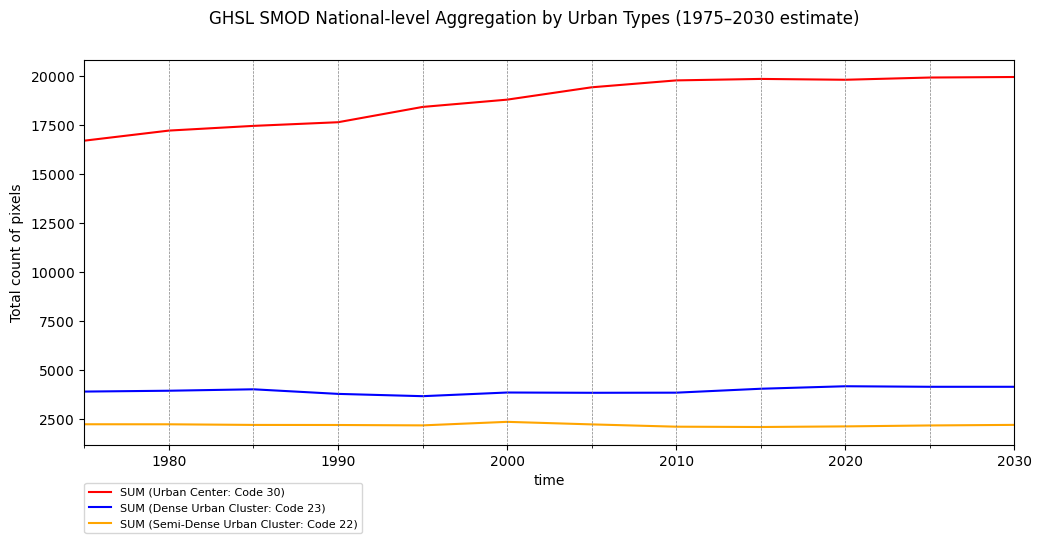

In [28]:
# Initalize Figure
fig = plt.figure(figsize = (12, 5))

# Add an ax to the fig
ax = fig.add_subplot(1, 1, 1)

df_temp = ds['SUM_urban'].to_dataframe()
ax = df_temp['SUM_urban'].plot(color = 'red', label = 'SUM (Urban Center: Code 30)')

df_temp = ds['SUM_dense'].to_dataframe()
ax = df_temp['SUM_dense'].plot(color = 'blue', label = 'SUM (Dense Urban Cluster: Code 23)')

df_temp = ds['SUM_semiDense'].to_dataframe()
ax = df_temp['SUM_semiDense'].plot(color = 'orange', label = 'SUM (Semi-Dense Urban Cluster: Code 22)')


# Add v-line
ax.axvline(x = '1975-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '1980-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '1985-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '1990-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '1995-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2000-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2005-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2010-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2015-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2020-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2025-01-01', color = 'grey', linestyle = '--', linewidth=0.5)



# Adjust the Y axis label
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.set_ylabel('Total count of pixels')

# Add a legend
ax.legend()
leg = ax.legend()
leg.get_frame().set_edgecolor('b')
leg.get_frame().set_linewidth(0.0)
ax.legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=8)

# Add fig title
fig.suptitle(title_file[0])

plt.show()

# Export fig
src_fig_temp = os.path.join(output_loc, title_file[1])
fig.savefig(src_fig_temp, bbox_inches="tight", dpi=300)

In [29]:
#File name
title_file = ["GHSL SMOD State-level Aggregation by Suburban-Rural types (1975–2030 estimate)", ISO + '_SMOD_national__suburb_rural.png']
print(title_file)

['GHSL SMOD State-level Aggregation by Suburban-Rural types (1975–2030 estimate)', 'JPN_SMOD_national__suburb_rural.png']


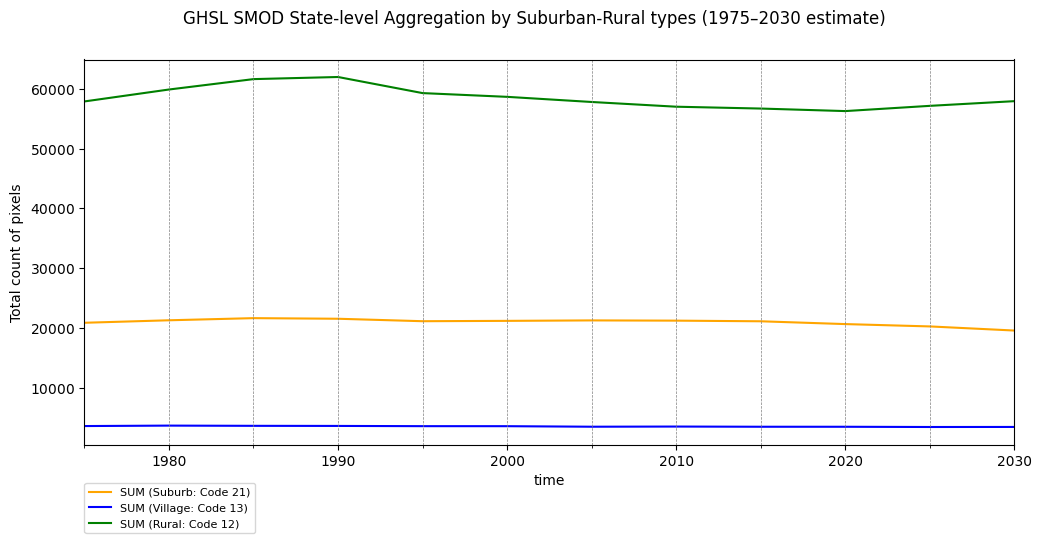

In [30]:
# Initalize Figure
fig = plt.figure(figsize = (12, 5))

# Add an ax to the fig
ax = fig.add_subplot(1, 1, 1)

df_temp = ds['SUM_suburb'].to_dataframe()
ax = df_temp['SUM_suburb'].plot(color = 'orange', label = 'SUM (Suburb: Code 21)')

df_temp = ds['SUM_village'].to_dataframe()
ax = df_temp['SUM_village'].plot(color = 'blue', label = 'SUM (Village: Code 13)')

df_temp = ds['SUM_rural'].to_dataframe()
ax = df_temp['SUM_rural'].plot(color = 'green', label = 'SUM (Rural: Code 12)')


# Add v-line
ax.axvline(x = '1975-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '1980-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '1985-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '1990-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '1995-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2000-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2005-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2010-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2015-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2020-01-01', color = 'grey', linestyle = '--', linewidth=0.5)
ax.axvline(x = '2025-01-01', color = 'grey', linestyle = '--', linewidth=0.5)



# Adjust the Y axis label
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.set_ylabel('Total count of pixels')

# Add a legend
ax.legend()
leg = ax.legend()
leg.get_frame().set_edgecolor('b')
leg.get_frame().set_linewidth(0.0)
ax.legend(bbox_to_anchor=(0, -0.1), loc='upper left', borderaxespad=0, fontsize=8)

# Add fig title
fig.suptitle(title_file[0])

plt.show()

# Export fig
src_fig_temp = os.path.join(output_loc, title_file[1])
fig.savefig(src_fig_temp, bbox_inches="tight", dpi=300)

In [31]:
# Map export if needed
ds['smod_val'].sel(time = '2000-01-01').rio.to_raster(os.path.join(output_loc, ISO + '_SMOD_national_1985.tif'))
ds['smod_val'].sel(time = '2030-01-01').rio.to_raster(os.path.join(output_loc, ISO + '_SMOD_national_2030.tif'))

## **Sub-national level analysis**

NOTE: You must prepare a subnational-level shapefile (adm-2,adm-3,adm-4, whatever)

In [36]:
gdf_tar.head(5)

,WHO_REGION,ISO_2_CODE,ADM2_NAME,ADM1_NAME,ADM0_NAME,ADM2_CODE,ADM1_CODE,ADM0_CODE,STARTDATE,ENDDATE,...,ADM0_VIZ_N,ADM2_SHAPE,ADM1_SHAPE,ADM0_SHAPE,ADM2_PCODE,ADM1_PCODE,ADM0_PCODE,WHO_SUBREG,CODE,geometry
560,WPRO,JP,HUKIAGETYOO,KAGOSIMA,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((11834521.382 3826809.918, 11835500.9..."
561,WPRO,JP,TORIDESI,IBARAKI,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((12312950.398 4329761.039, 12313104.4..."
562,WPRO,JP,OOTAKIMATI,TIBA,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((12389641.559 4260373.313, 12390588.9..."
563,WPRO,JP,URASOESI,OKINAWA,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"POLYGON ((11964752.858 3204925.503, 11965054.3..."
564,WPRO,JP,UDONOMURA,MIE,JAPAN,None,None,None,2000-01-01,9999/12/31,...,Japan,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((12160079.018 4076558.248, 1216..."


In [37]:
# Convert to an UTM:
gdf_tar.to_crs(UTM_crs, inplace = True)

gdf_tar['AREA'] = gdf_tar.area / 1000000#km2

gdf_tar.to_crs('ESRI:54009', inplace = True)# NBack to 54009 (This is the CRS of the GHSL-POP)

In [38]:
# Check the territorial size if it is not deviated from the true size (there is always some deviation)
print(f"{gdf_tar['AREA'].sum():,.0f} km²")

378,441 km²


In [39]:
# Area code:
areaUniqueCode = unique_ID

In [40]:
ds.SUM_dense.time

<xarray.DataArray 'time' (time: 12)> Size: 96B
array(['1975-01-01T00:00:00.000000000', '1980-01-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '2005-01-01T00:00:00.000000000', '2010-01-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2025-01-01T00:00:00.000000000', '2030-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 96B 1975-01-01 1980-01-01 ... 2030-01-01

In [41]:
# Constructing target year list.

li_time = []

for i in range(0, 12):
  y = 1975 + (i * 5)
  time_temp = str(y) + '-01-01'
  li_time.append(time_temp)

li_time

['1975-01-01',
 '1980-01-01',
 '1985-01-01',
 '1990-01-01',
 '1995-01-01',
 '2000-01-01',
 '2005-01-01',
 '2010-01-01',
 '2015-01-01',
 '2020-01-01',
 '2025-01-01',
 '2030-01-01']

In [42]:
#dic_type = {'urban': 30, 'dense': 23, 'semiDense':22, 'suburb':21, 'village':13, 'rural':12, 'noPer':11}
dic_type = {'urb': 30, 'den': 23, 'sem':22, 'sub':21, 'vil':13, 'rur':12, 'noP':11}

In [44]:
gdf_2merge = gdf_tar[[unique_ID, 'AREA', 'geometry']].copy()
gdf_2merge

,GUID,AREA,geometry
560,0017d495-3b52-429f-8c43-bdce5088a607,97.286121,"POLYGON ((11834521.382 3826809.918, 11835500.9..."
561,0024be18-42e6-4d60-92be-14821f9509dc,44.083985,"POLYGON ((12312950.398 4329761.039, 12313104.4..."
562,0043e24f-63ed-4f90-835b-de0ca8d5c316,129.590695,"POLYGON ((12389641.559 4260373.313, 12390588.9..."
563,00685ca7-107f-4b1c-b93d-4d7d6f648f8f,20.706482,"POLYGON ((11964752.858 3204925.503, 11965054.3..."
564,006be846-9d23-4f81-9a23-924ecfe89b6a,2.332992,"MULTIPOLYGON (((12160079.018 4076558.248, 1216..."
...,...,...,...
3895,1b4bd89b-4bf0-4a77-885e-26632d9c871c,30.018478,"MULTIPOLYGON (((11820396.151 3029857.109, 1181..."
3896,8d4089ab-9a73-4edc-a2a8-ccac664d61a2,7.492521,"POLYGON ((11770795.52 4077878.406, 11772478.05..."
3897,1b0adff3-1b8e-483e-b8db-caa467026649,5.781317,"POLYGON ((12609601.887 3928807.556, 12608750.8..."
3898,93b632d4-c159-4377-8a0f-1dc88c593be1,20.984356,"POLYGON ((12392879.688 4136464.354, 12395848.5..."


In [45]:
## Count the pixels of each SMOD class per year per subnational area.

for y in li_time:
  print(y)

  for key, value in dic_type.items():



      ds[key] = ds['smod_val'].where(ds['smod_val'] == value).sel(time = y)

      # EXACT-EXTRACT

      agg_query = key + '=sum(coverage_weight=none)'
      gdf_temp = exactextract.exact_extract(ds[key].where(ds[key] > 0),
                                    gdf_tar,
                                    agg_query,
                                    include_cols=[areaUniqueCode],
                                    output='pandas')

      gdf_temp[key] = gdf_temp[key] / value
      gdf_temp[key] = gdf_temp[key].astype(int)
      gdf_temp = gdf_temp.rename(columns ={key : key + '_' + y[:4]})

      gdf_2merge = gdf_2merge.merge(gdf_temp, on = areaUniqueCode, how = 'left')

1975-01-01
1980-01-01
1985-01-01
1990-01-01
1995-01-01
2000-01-01
2005-01-01
2010-01-01
2015-01-01
2020-01-01
2025-01-01
2030-01-01


In [46]:
gdf_2merge.head(5)

,GUID,AREA,geometry,urb_1975,den_1975,sem_1975,sub_1975,vil_1975,rur_1975,noP_1975,...,vil_2025,rur_2025,noP_2025,urb_2030,den_2030,sem_2030,sub_2030,vil_2030,rur_2030,noP_2030
0,0017d495-3b52-429f-8c43-bdce5088a607,97.286121,"POLYGON ((11834521.382 3826809.918, 11835500.9...",0,0,0,0,5,40,74,...,5,35,79,0,0,0,0,5,35,79
1,0024be18-42e6-4d60-92be-14821f9509dc,44.083985,"POLYGON ((12312950.398 4329761.039, 12313104.4...",8,17,0,31,0,21,6,...,0,13,0,50,0,0,20,0,13,0
2,0043e24f-63ed-4f90-835b-de0ca8d5c316,129.590695,"POLYGON ((12389641.559 4260373.313, 12390588.9...",0,0,0,0,5,32,132,...,0,43,118,0,0,0,0,7,44,118
3,00685ca7-107f-4b1c-b93d-4d7d6f648f8f,20.706482,"POLYGON ((11964752.858 3204925.503, 11965054.3...",27,0,0,0,0,0,0,...,0,0,0,27,0,0,0,0,0,0
4,006be846-9d23-4f81-9a23-924ecfe89b6a,2.332992,"MULTIPOLYGON (((12160079.018 4076558.248, 1216...",0,5,0,1,0,0,0,...,0,0,0,0,5,0,1,0,0,0


In [47]:
# Export (CSV)
outfil_name = ISO + '_SMOD_SubNational.csv'

gdf_2merge.drop(columns='geometry').to_csv(os.path.join(output_loc, outfil_name))

In [48]:
# If you want export the result as a Shpefile:
outfil_name = ISO + '_SMOD_subnational.shp'

gdf_2merge.to_crs('EPSG:4326', inplace = True)# Back to WGS 1984: EPSG4326.
tools.vec_export(RW_engine, gdf_2merge, os.path.join(output_loc, outfil_name))

Vector export complete.
